# <center>Wasserstein Generative Adversarial Network (WGAN) for NSL-KDD <center/>

Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.stats import norm

from preprocessing import *
from classifiers import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras import optimizers

## Define the Critic loss and critic model

In [3]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(data_dim, base_n_neurones,lr = 0.00005):
    model = Sequential(name="critic")
    
    model.add(Dense(base_n_neurones*2, activation='tanh',input_dim = data_dim ))
    model.add(Dense(base_n_neurones, activation='tanh'))
    model.add(Dense(base_n_neurones//2, activation='tanh'))
    model.add(Dense(1))
    
    opt = optimizers.RMSprop(lr=lr)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return model

## Define generator model

In [4]:
def define_generator(data_dim, base_n_neurones,noise_dim):
    
    model = Sequential(name='Generator')
    
    model.add(Dense(base_n_neurones, activation='relu',input_dim = noise_dim ))
    model.add(Dense(base_n_neurones*2, activation='relu'))
    model.add(Dense(base_n_neurones*3, activation='relu'))
    
    model.add(Dense(data_dim))
    
    return model

## Define Combined Model (GAN => D(G(z)))

In [12]:
def define_gan(generator, critic,lr=0.00005):
    # make critic not trainable
    critic.trainable = False
    model = Sequential(name="combined")
    
    # add generator & critic
    model.add(generator)
    model.add(critic)
    
    # compile model
    opt = optimizers.RMSprop(lr=lr)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return model

## Helper methods definitions

In [13]:
def get_batch(X, batch_size=1):
    batch_ix = np.random.choice(len(X), batch_size, replace=False)
    return X[batch_ix]

def critic_accuracy(model , x , g_z):
    real_label = -np.ones(len(x),dtype=np.int)
    real_pred = [-1 if i < 0.0 else 1 for i in model.predict(x).ravel()]
    acc1 = accuracy_score(real_label,real_pred)
    
    gen_label = np.ones(len(x),dtype=np.int)
    gen_pred = [-1 if i < 0.0 else 1 for i in model.predict(g_z).ravel()]
    acc2 = accuracy_score(gen_label, gen_pred)
    
    print("Critic accuracy on Real : {} , Fake : {}".format(acc1,acc2))
    
def plot_distributions(real_dist,generated_dist):
    kl_values = np.sum(np.where(real_dist != 0, real_dist * np.log(real_dist/generated_dist),0),axis=1)
    top_3 = np.argsort(kl_values)[:3]
    bottom = np.argsort(kl_values)[-3:]

    tot_features = top_3.tolist() + bottom.tolist()
    sns.set(rc={'figure.figsize':(12,8)},font_scale=1.3)
    fig, axes = plt.subplots(nrows=2, ncols=3)
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle('Distributions of Features')

    for ax, feature, name in zip(axes.flatten(), tot_features , tot_features):
        sns.distplot(real_dist[feature], hist = False, kde = True, ax = ax,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "Real")
        sns.distplot(generated_dist[feature], hist = False, kde = True,ax = ax,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "Fake")

        ax.set(title=f'Feature #{name}')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Define train procedure 

In [14]:
def training(dataset, base_n_neurones , rand_dim, n_epochs=10, batch_size=64, n_critic=5):
    
    data_dim = dataset.shape[1]
    clip_value = 0.01
    
    g_model = define_generator(data_dim,base_n_neurones,rand_dim)
    c_model = define_critic(data_dim,base_n_neurones)
    combined = define_gan(g_model,c_model)
    
    bat_per_epo = int(dataset.shape[0] / batch_size)
    tot_epochs = bat_per_epo * n_epochs
    half_batch = int(batch_size / 2)
    
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    
    for i in range(tot_epochs):
        c_model.trainable = True
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real = get_batch(dataset, half_batch)
            
            #Train Critic / discriminator on real
            #c_loss1 = c_model.train_on_batch(X_real, -np.ones(half_batch))
            c_loss1 = c_model.train_on_batch(X_real, -np.random.uniform(low=0.999, high=1.0, size=half_batch))
            c1_tmp.append(c_loss1)
            
            z = np.random.normal(size=(half_batch, rand_dim))
            X_fake = g_model.predict(z)
            #y_fake = np.ones((half_batch, 1))
            
            #Train Critic / discriminator on fake
            #c_loss2 = c_model.train_on_batch(X_fake, np.ones(half_batch))
            c_loss2 = c_model.train_on_batch(X_fake, np.random.uniform(low=0.999, high=1.0, size=half_batch))
            
            c2_tmp.append(c_loss2)
            
            #Clip the weights
            for layer in c_model.layers:
                weights = layer.get_weights()
                weights = [np.clip(weight, -clip_value, clip_value) for weight in weights]
                layer.set_weights(weights)
            
        c_model.trainable = False
        
        # store critic loss
        c1_hist.append(np.mean(c1_tmp))
        c2_hist.append(np.mean(c2_tmp))
        
        z = np.random.normal(size=(batch_size, rand_dim))
        
        # Train generator via the critic's error
        #g_loss = combined.train_on_batch(z, -np.ones(batch_size))
        g_loss = combined.train_on_batch(z, -np.random.uniform(low=0.999, high=1.0, size=batch_size))
        g_hist.append(g_loss)
        
        if i % 10 == 0 :
            print("Epoch : {} , Generator loss {:.6f} ".format(i+1, g_loss))
            z = np.random.normal(size=(len(dataset), rand_dim))
            g_z = g_model.predict(z)
            critic_accuracy(model = c_model, g_z = g_z , x = dataset)
            
            p = norm.pdf(dataset.T)
            q = norm.pdf(g_z.T)
            
            norm_p = p/p.sum(axis=1,keepdims=1)
            norm_q = q/q.sum(axis=1,keepdims=1)
        if i % 100 == 0 :
            plot_distributions(generated_dist=norm_q, real_dist=norm_p)
        
    return dict({"generator_model":g_model,"critic_model":c_model,\
            "combined_model":combined,"generator_loss":g_hist,\
            "disc_loss_generated":c2_hist,"disc_loss_real": c1_hist})


## Load Data

In [15]:
train,test, label_mapping = get_data(encoding="Label")
data_cols = list(train.columns[ train.columns != 'label' ])
x_train , x_test = preprocess(train,test,data_cols,"Robust",True)

y_train = x_train.label.values
y_test = x_test.label.values

data_cols = list(x_train.columns[ x_train.columns != 'label' ])

att_ind = np.where(y_train == label_mapping["probe"])[0]

dataset = x_train[data_cols].values[att_ind]

In [16]:
label_mapping
# dataset.shape

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

## Define and declare training parameters

In [17]:
base_n_neurones = 100

epochs = 1000
batch_size = 64
rand_dim = 32

## Train Models

Epoch : 1 , Generator loss -0.000080 
Critic accuracy on Real : 0.00025737817433081676 , Fake : 1.0


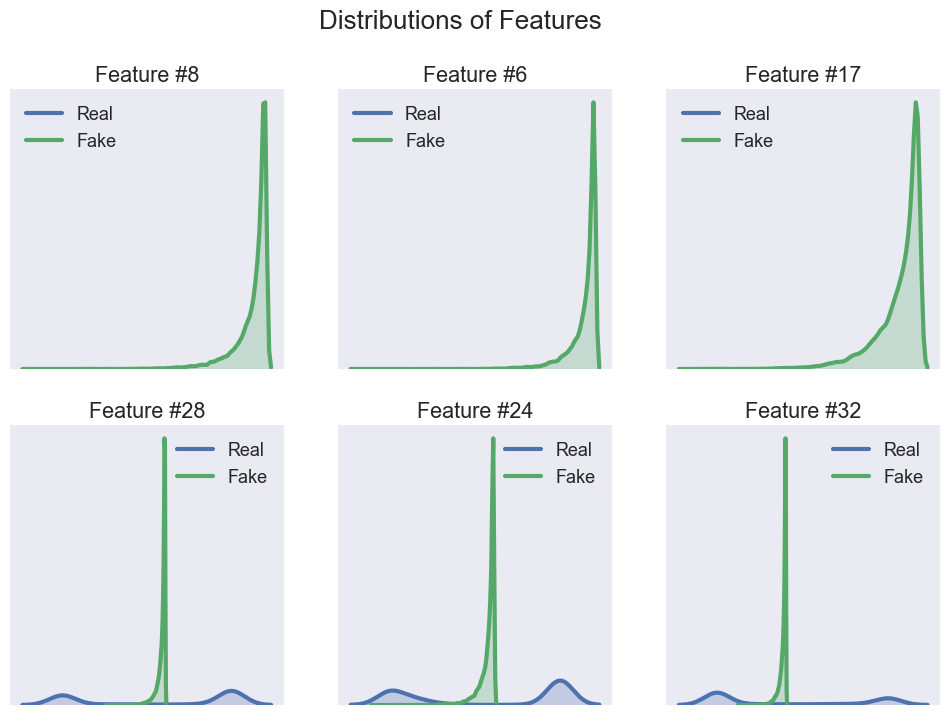

Epoch : 11 , Generator loss -0.000107 
Critic accuracy on Real : 0.00025737817433081676 , Fake : 1.0
Epoch : 21 , Generator loss -0.000102 
Critic accuracy on Real : 0.00025737817433081676 , Fake : 1.0
Epoch : 31 , Generator loss -0.000068 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 41 , Generator loss -0.000042 
Critic accuracy on Real : 8.579272477693891e-05 , Fake : 0.9532429649965682
Epoch : 51 , Generator loss -0.000077 
Critic accuracy on Real : 0.0004289636238846946 , Fake : 0.9461221688400824
Epoch : 61 , Generator loss -0.000217 
Critic accuracy on Real : 0.0006005490734385724 , Fake : 0.997254632807138
Epoch : 71 , Generator loss -0.000316 
Critic accuracy on Real : 0.0007721345229924502 , Fake : 1.0
Epoch : 81 , Generator loss -0.000341 
Critic accuracy on Real : 0.0006863417982155113 , Fake : 1.0
Epoch : 91 , Generator loss -0.000312 
Critic accuracy on Real : 0.0004289636238846946 , Fake : 1.0
Epoch : 101 , Generator loss -0.000228 
Critic accuracy on Real : 0.0008

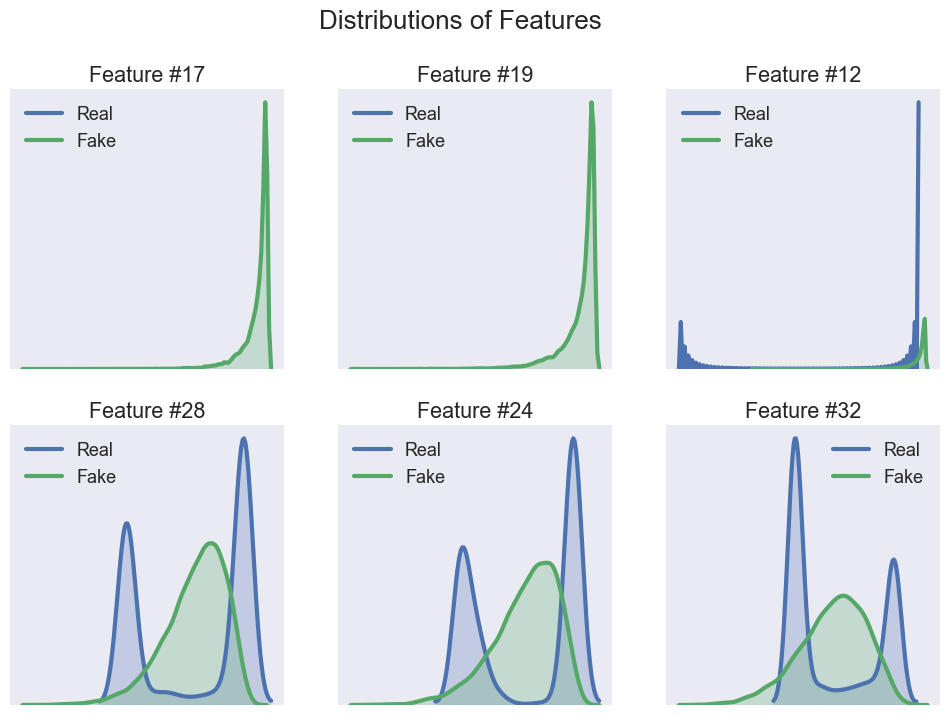

Epoch : 111 , Generator loss -0.000126 
Critic accuracy on Real : 0.0006863417982155113 , Fake : 1.0
Epoch : 121 , Generator loss -0.000048 
Critic accuracy on Real : 0.0007721345229924502 , Fake : 0.9999142072752231
Epoch : 131 , Generator loss -0.000000 
Critic accuracy on Real : 0.04727179135209334 , Fake : 0.6324639670555937
Epoch : 141 , Generator loss 0.000017 
Critic accuracy on Real : 0.404512697323267 , Fake : 0.25609128345916266
Epoch : 151 , Generator loss 0.000006 
Critic accuracy on Real : 0.3908716540837337 , Fake : 0.4685140700068634
Epoch : 161 , Generator loss -0.000023 
Critic accuracy on Real : 0.043239533287577216 , Fake : 0.9444063143445436
Epoch : 171 , Generator loss -0.000057 
Critic accuracy on Real : 0.0007721345229924502 , Fake : 1.0
Epoch : 181 , Generator loss -0.000068 
Critic accuracy on Real : 0.00034317089910775565 , Fake : 1.0
Epoch : 191 , Generator loss -0.000073 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 201 , Generator loss -0.000074 
Crit

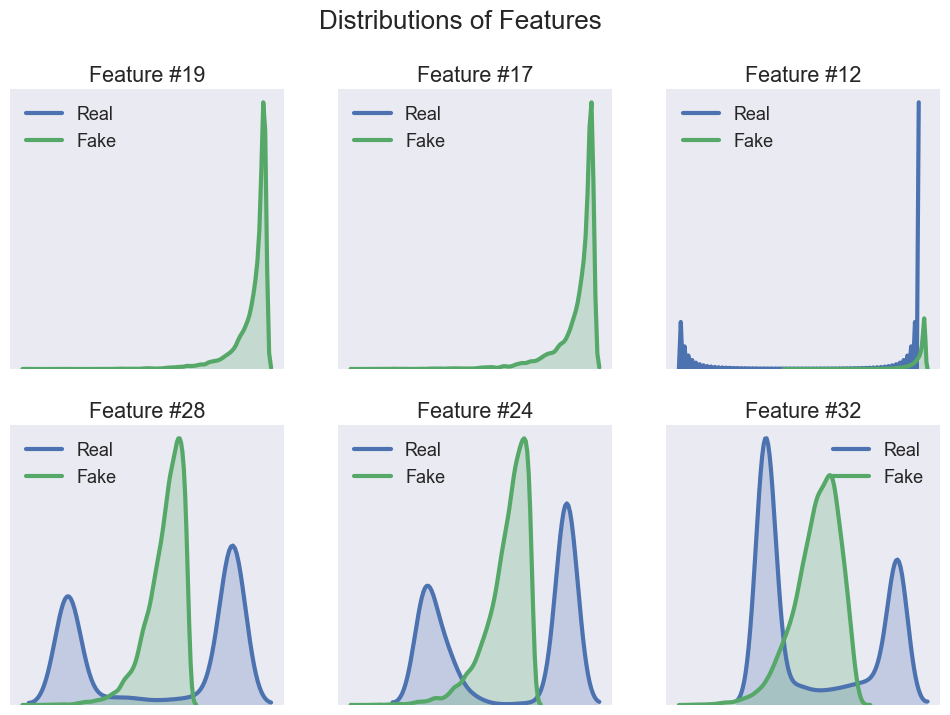

Epoch : 211 , Generator loss -0.000077 
Critic accuracy on Real : 8.579272477693891e-05 , Fake : 1.0
Epoch : 221 , Generator loss -0.000074 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 231 , Generator loss -0.000071 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 241 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 251 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 261 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 271 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 281 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 291 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 301 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


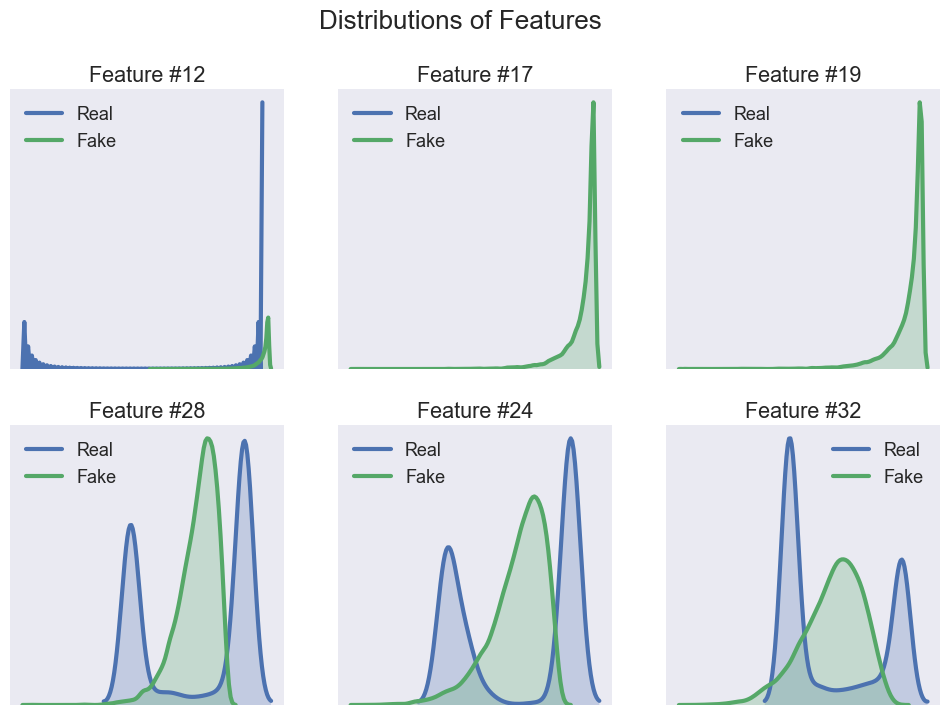

Epoch : 311 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 321 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 331 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 341 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 351 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 361 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 371 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 381 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 391 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 401 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


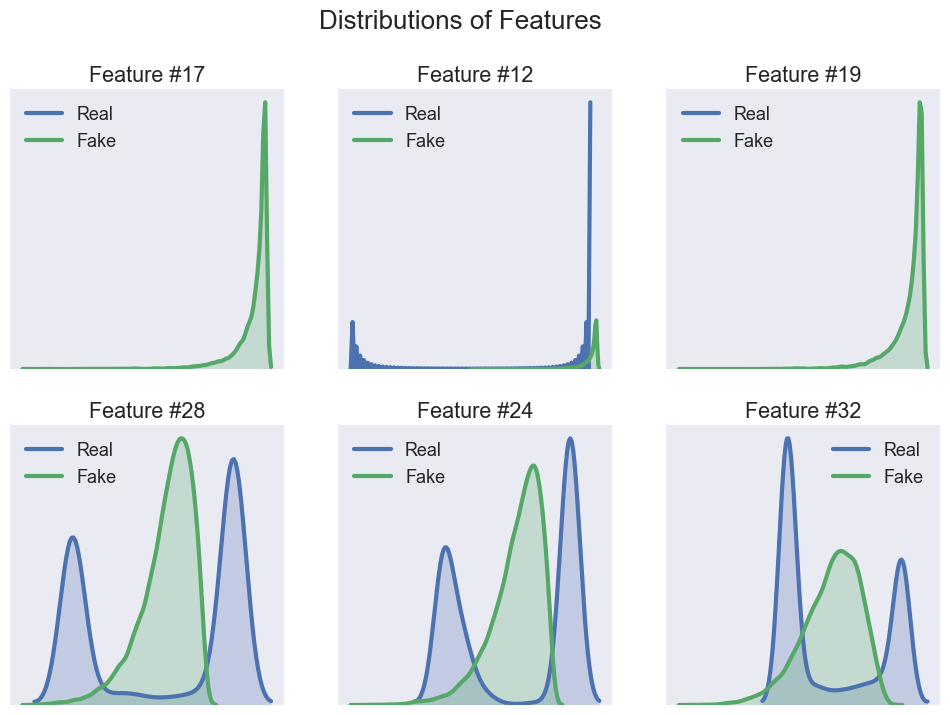

Epoch : 411 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 421 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 431 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 441 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 451 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 461 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 471 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 481 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 491 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 501 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


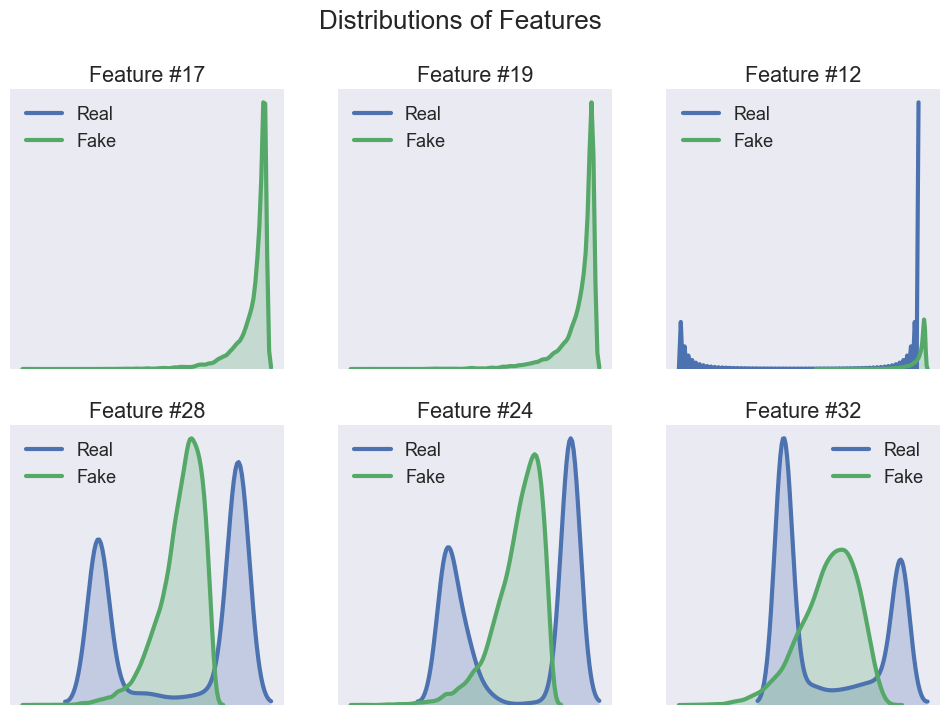

Epoch : 511 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 521 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 531 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 541 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 551 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 561 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 571 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 581 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 591 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 601 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0


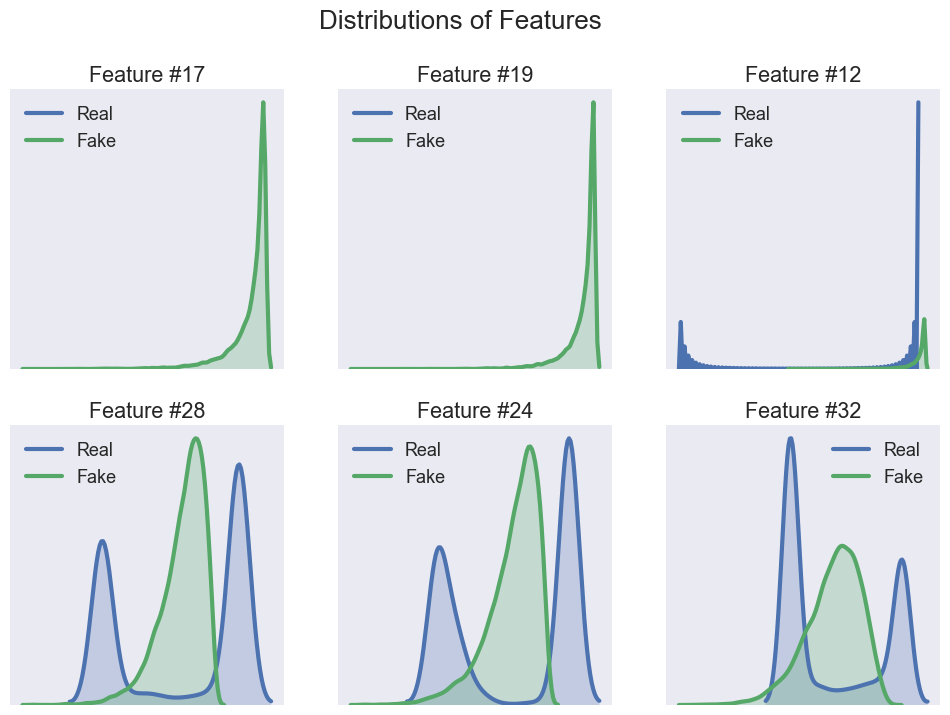

Epoch : 611 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 621 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 631 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 641 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 651 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 661 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 671 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 681 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 691 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 701 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


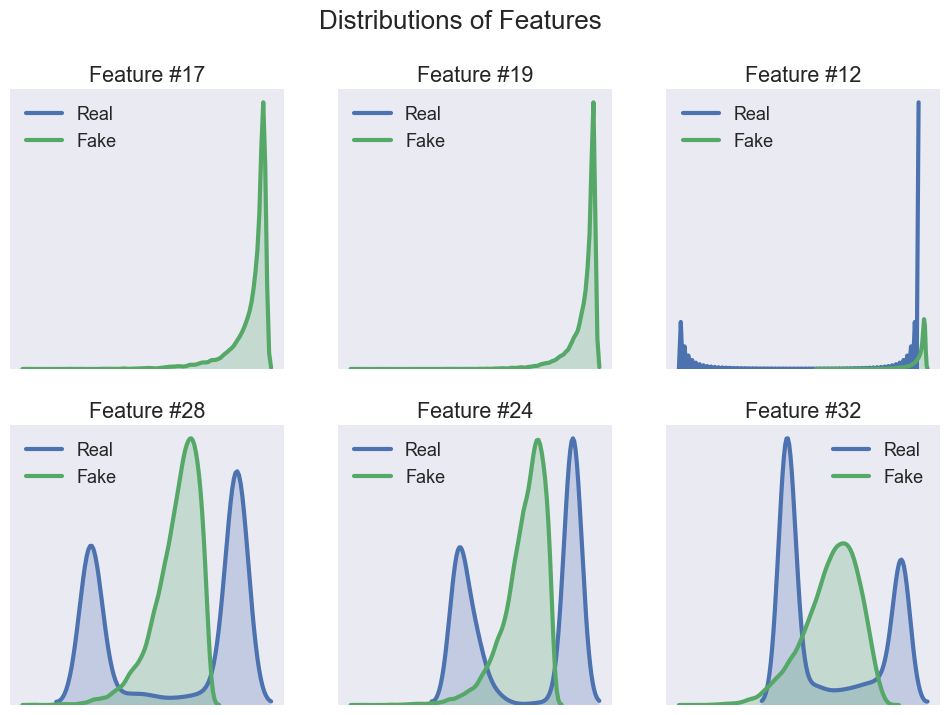

Epoch : 711 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 721 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 731 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 741 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 751 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 761 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 771 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 781 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 791 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 801 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0


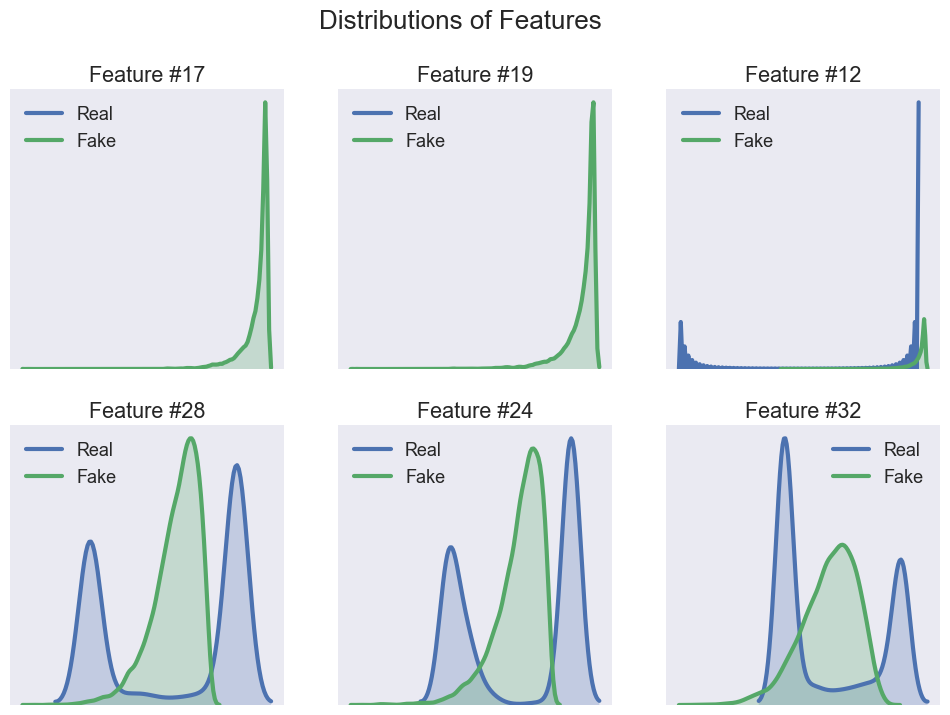

Epoch : 811 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 821 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 831 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 841 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 851 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 861 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 871 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 881 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 891 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 901 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


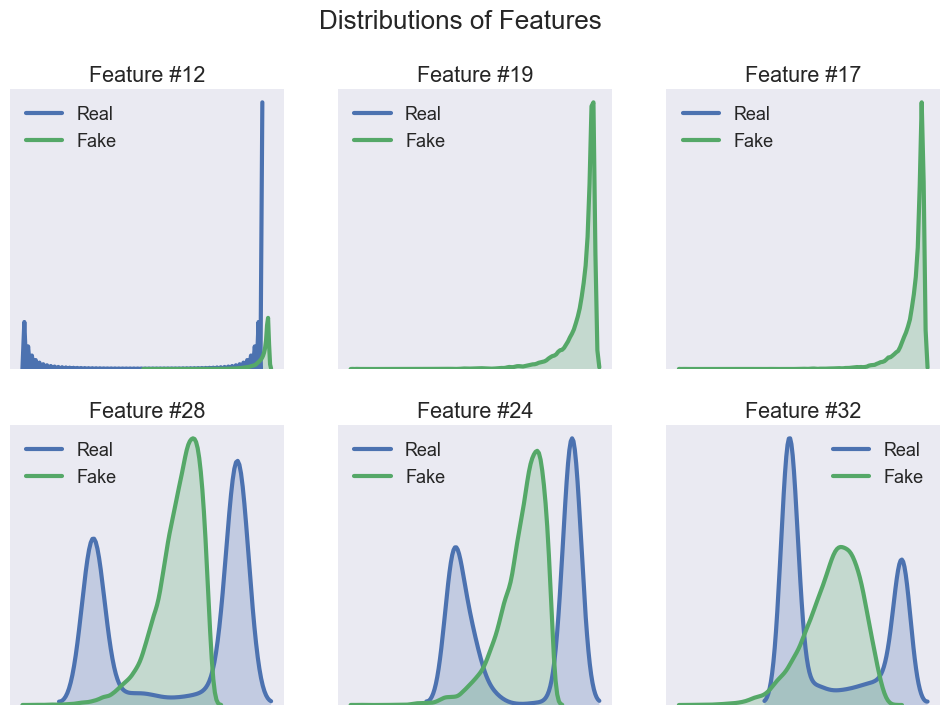

Epoch : 911 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 921 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 931 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 941 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 951 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 961 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 971 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 981 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 991 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1001 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


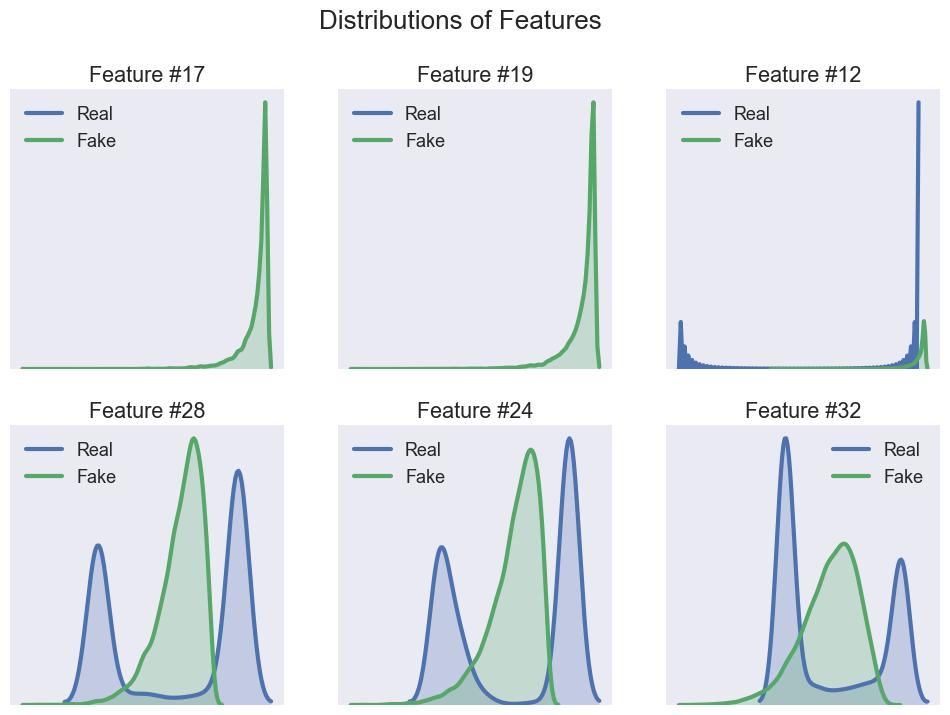

Epoch : 1011 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1021 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1031 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1041 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1051 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1061 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1071 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1081 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1091 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1101 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


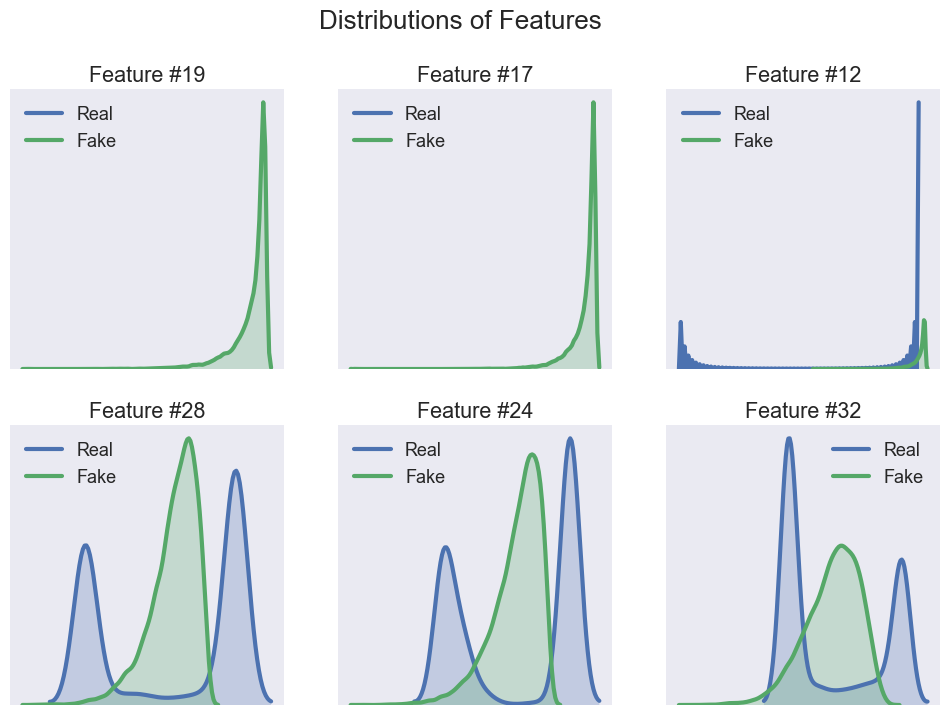

Epoch : 1111 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1121 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1131 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1141 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1151 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1161 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1171 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1181 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1191 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1201 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


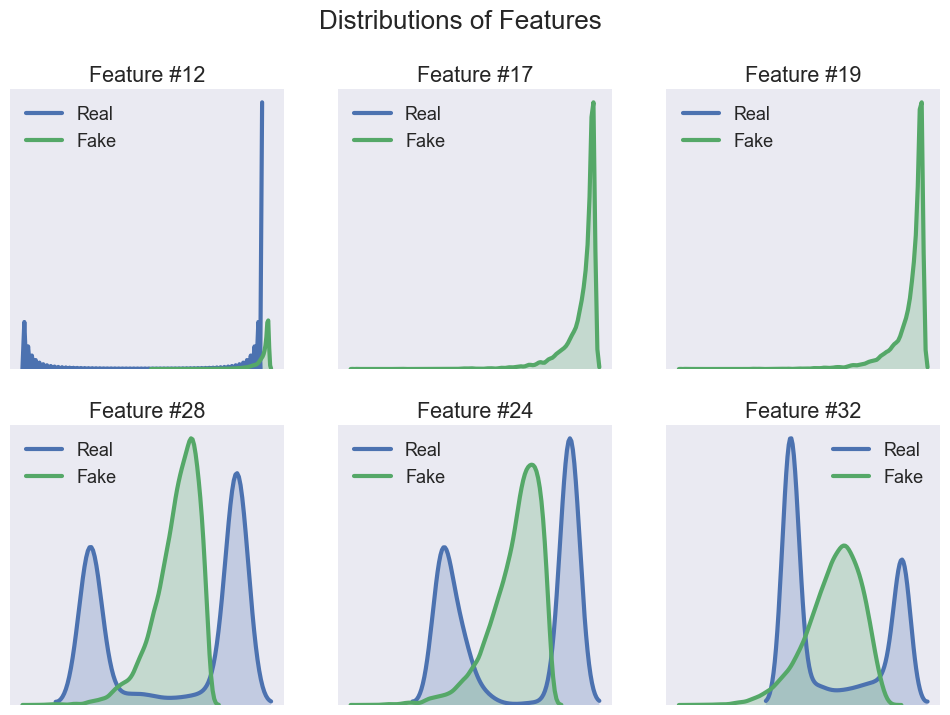

Epoch : 1211 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1221 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1231 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1241 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1251 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1261 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1271 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1281 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1291 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1301 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


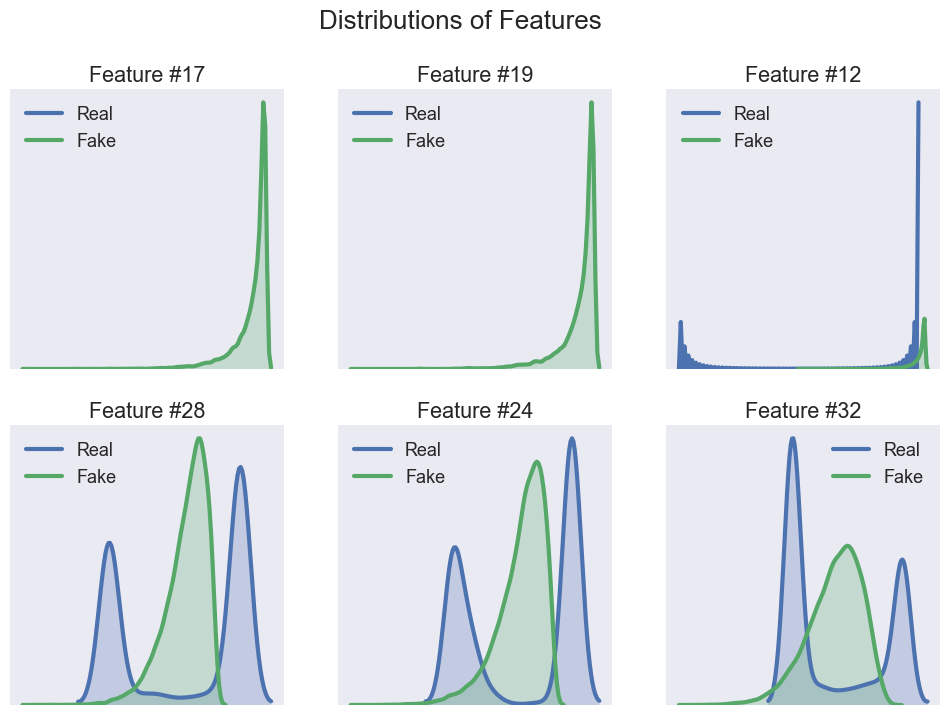

Epoch : 1311 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1321 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1331 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1341 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1351 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1361 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1371 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1381 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1391 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1401 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


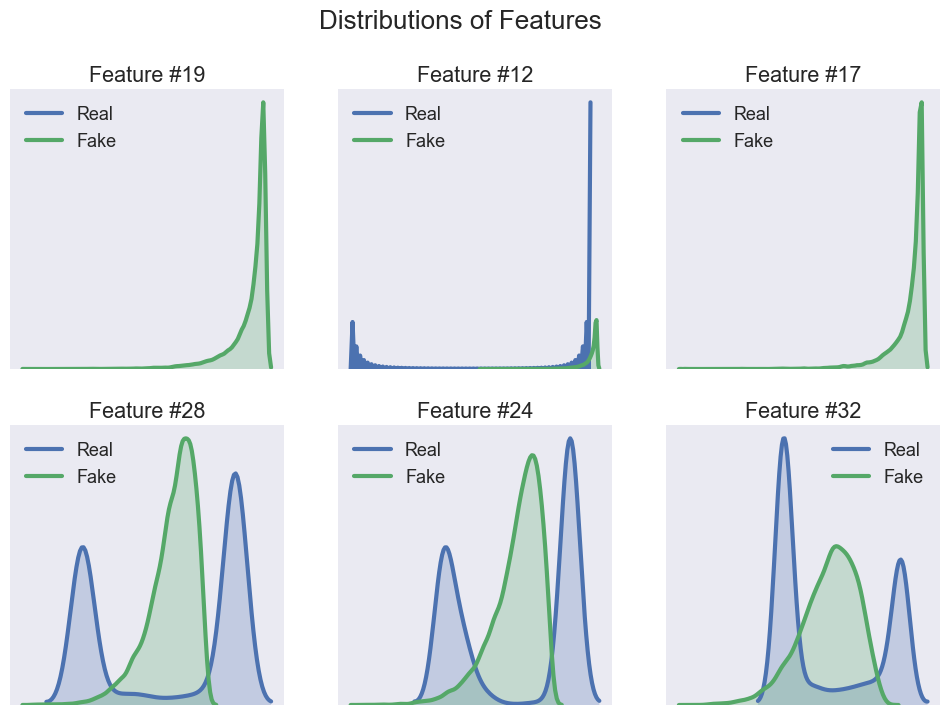

Epoch : 1411 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1421 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1431 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1441 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1451 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1461 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1471 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1481 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1491 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1501 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


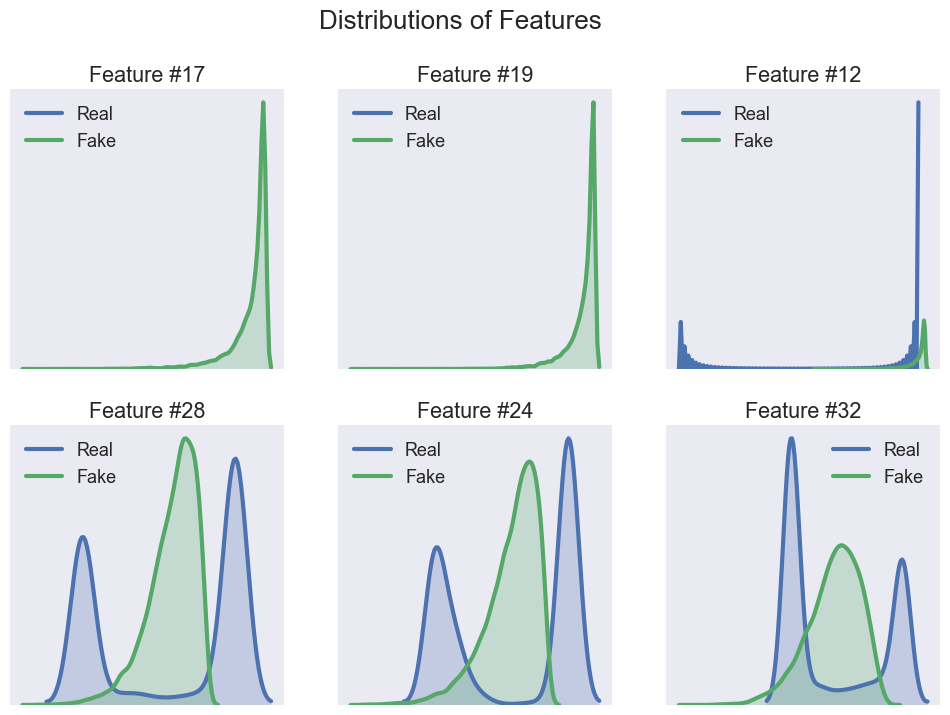

Epoch : 1511 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1521 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1531 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1541 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1551 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1561 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1571 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1581 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1591 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1601 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


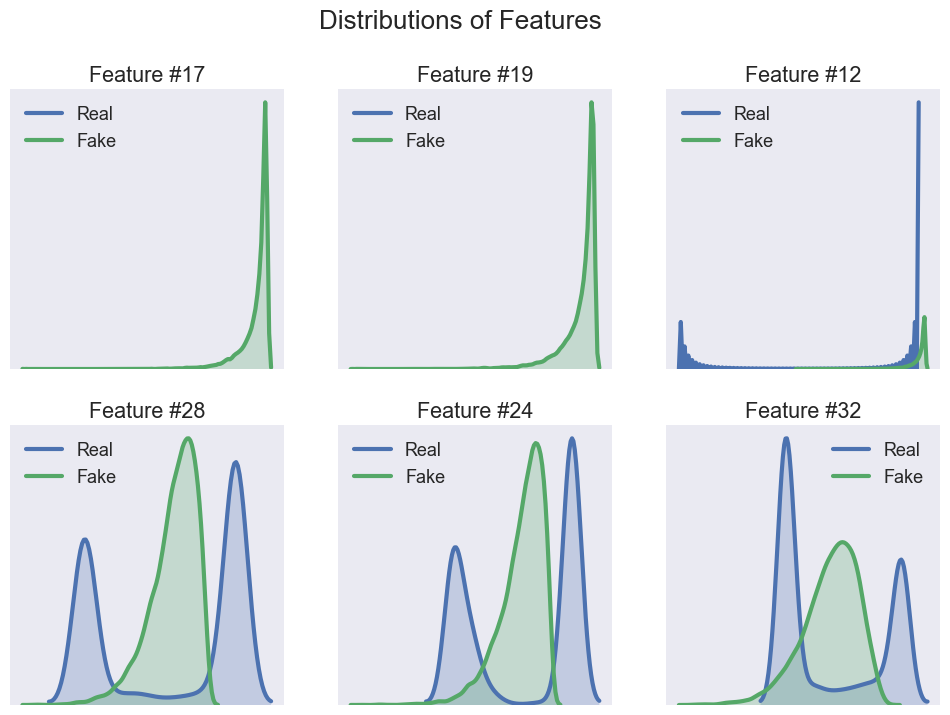

Epoch : 1611 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1621 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1631 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1641 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1651 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1661 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1671 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1681 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1691 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1701 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


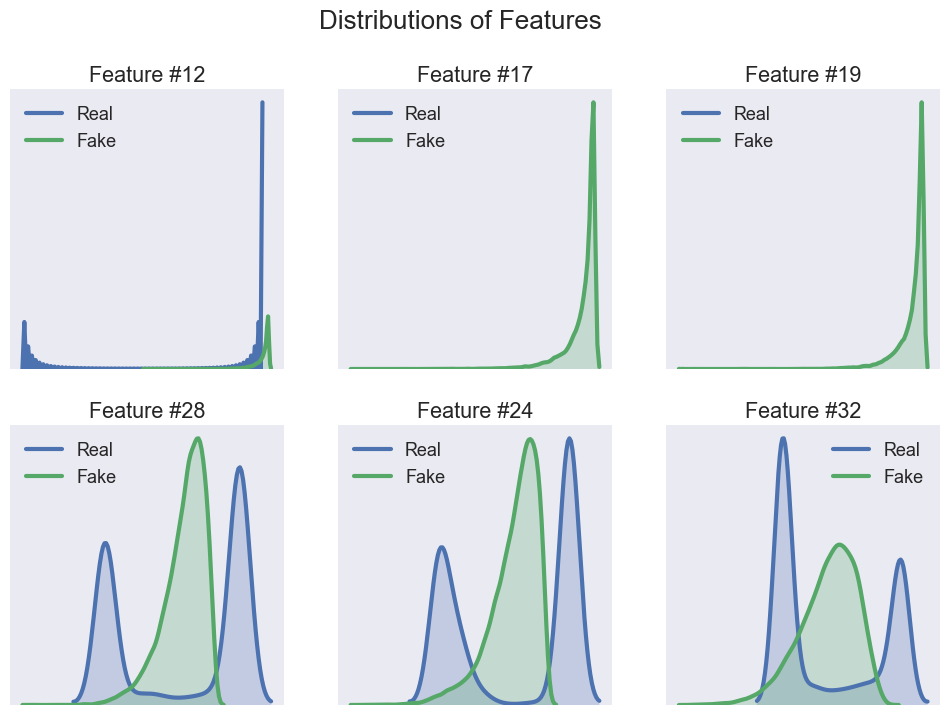

Epoch : 1711 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1721 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1731 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1741 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1751 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1761 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1771 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1781 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1791 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1801 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


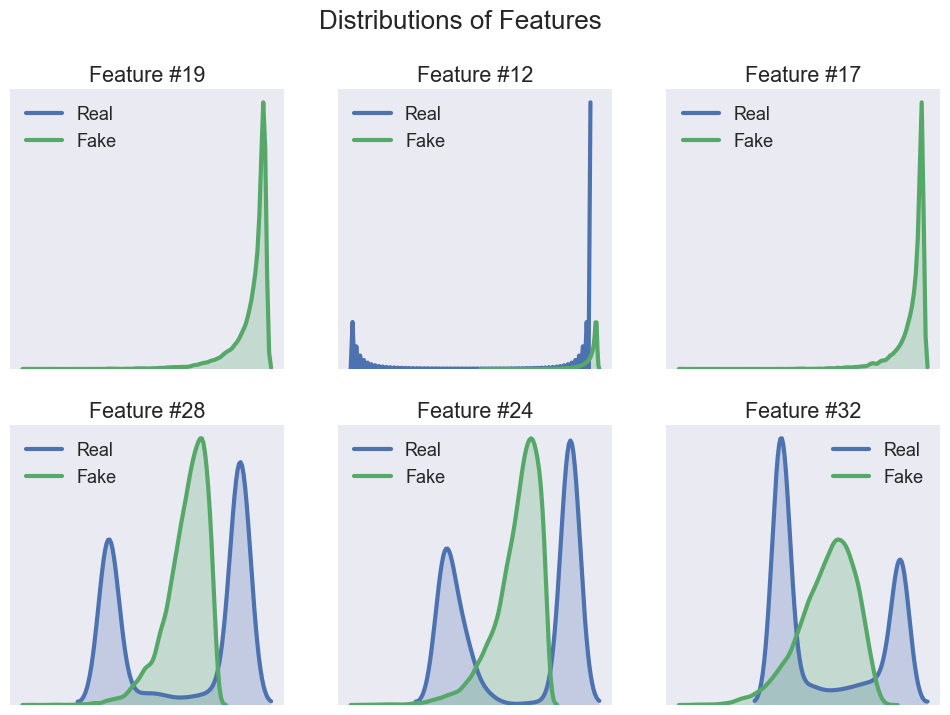

Epoch : 1811 , Generator loss -0.000069 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1821 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1831 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1841 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1851 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1861 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1871 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1881 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1891 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1901 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


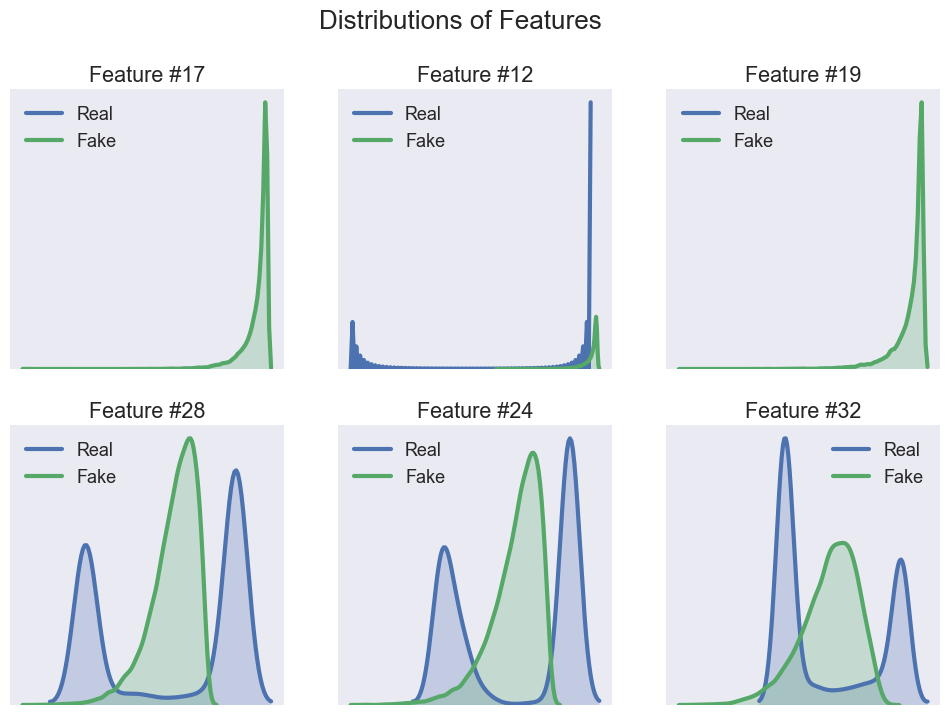

Epoch : 1911 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1921 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1931 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1941 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1951 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1961 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1971 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1981 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 1991 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2001 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


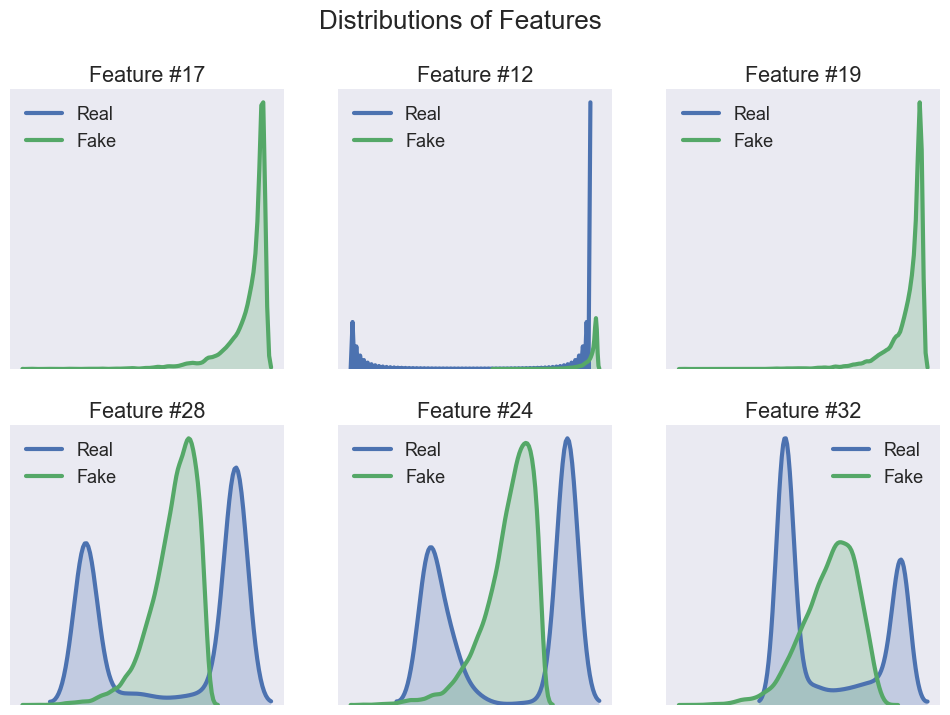

Epoch : 2011 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2021 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2031 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2041 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2051 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2061 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2071 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2081 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2091 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2101 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


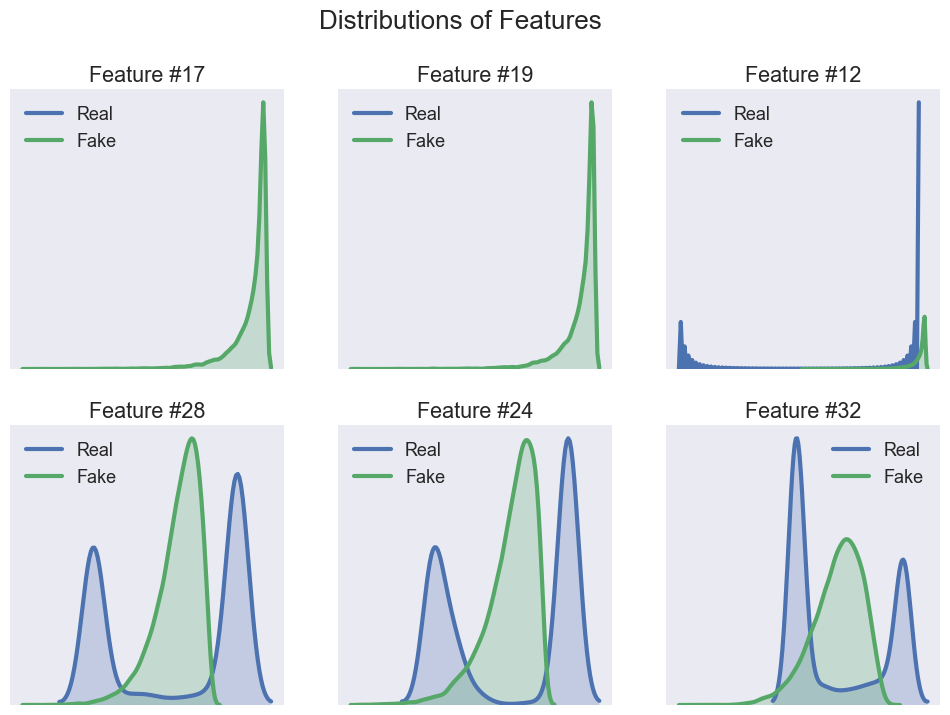

Epoch : 2111 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2121 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2131 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2141 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2151 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2161 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2171 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2181 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2191 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2201 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


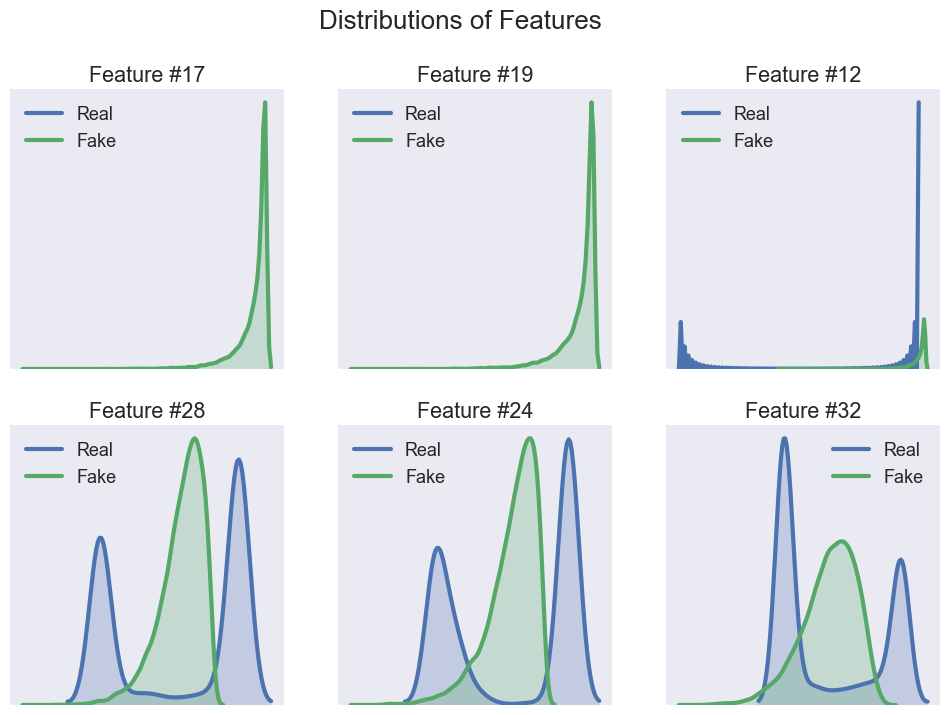

Epoch : 2211 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2221 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2231 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2241 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2251 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2261 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2271 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2281 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2291 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2301 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


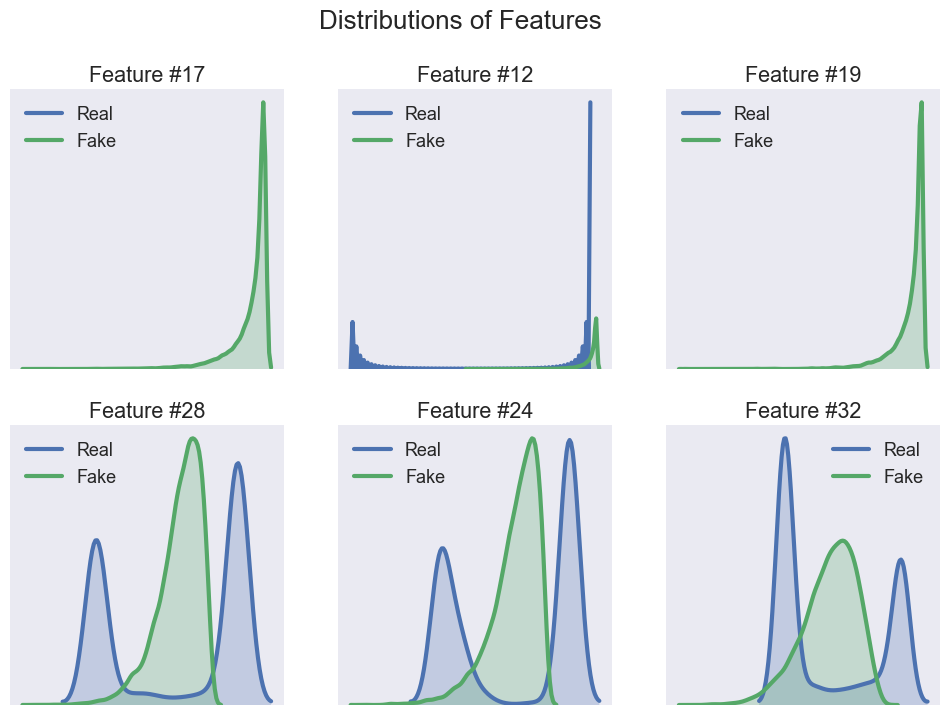

Epoch : 2311 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2321 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2331 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2341 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2351 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2361 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2371 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2381 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2391 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2401 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


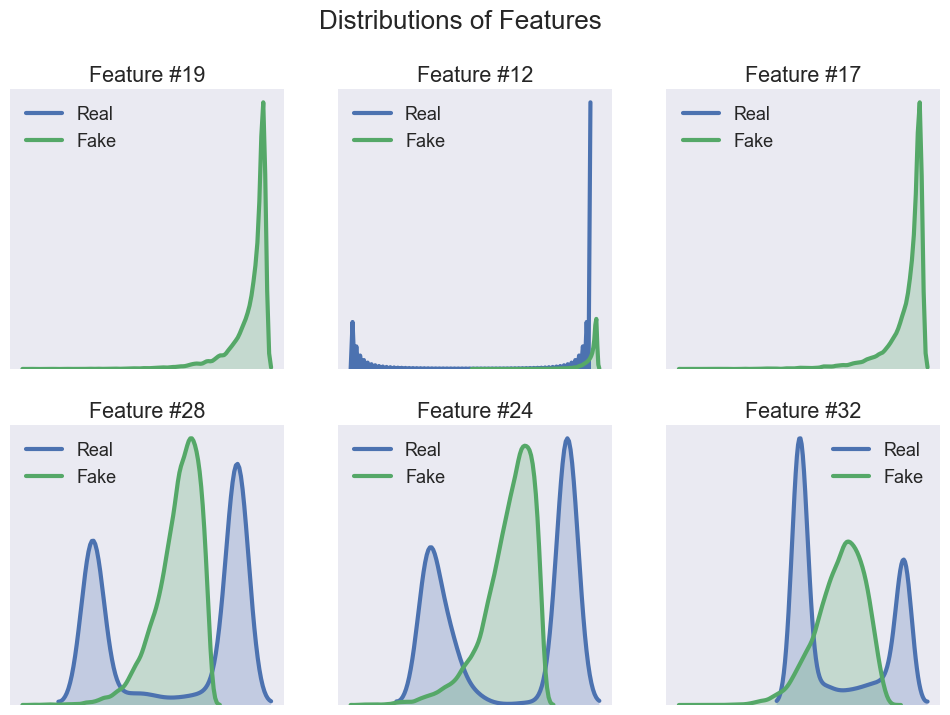

Epoch : 2411 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2421 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2431 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2441 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2451 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2461 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2471 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2481 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2491 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2501 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


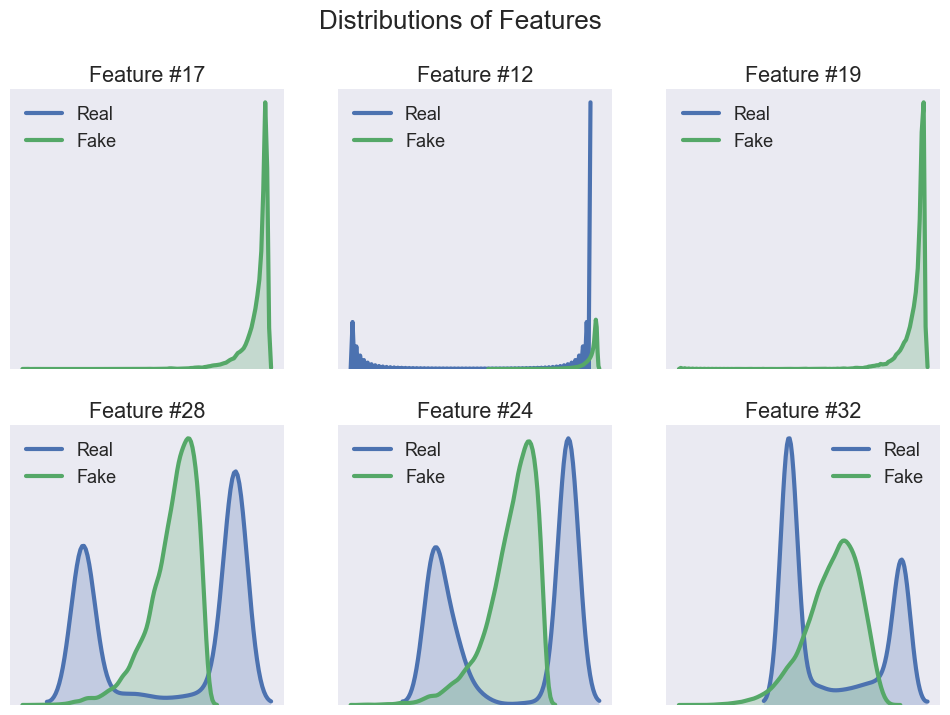

Epoch : 2511 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2521 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2531 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2541 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2551 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2561 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2571 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2581 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2591 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2601 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


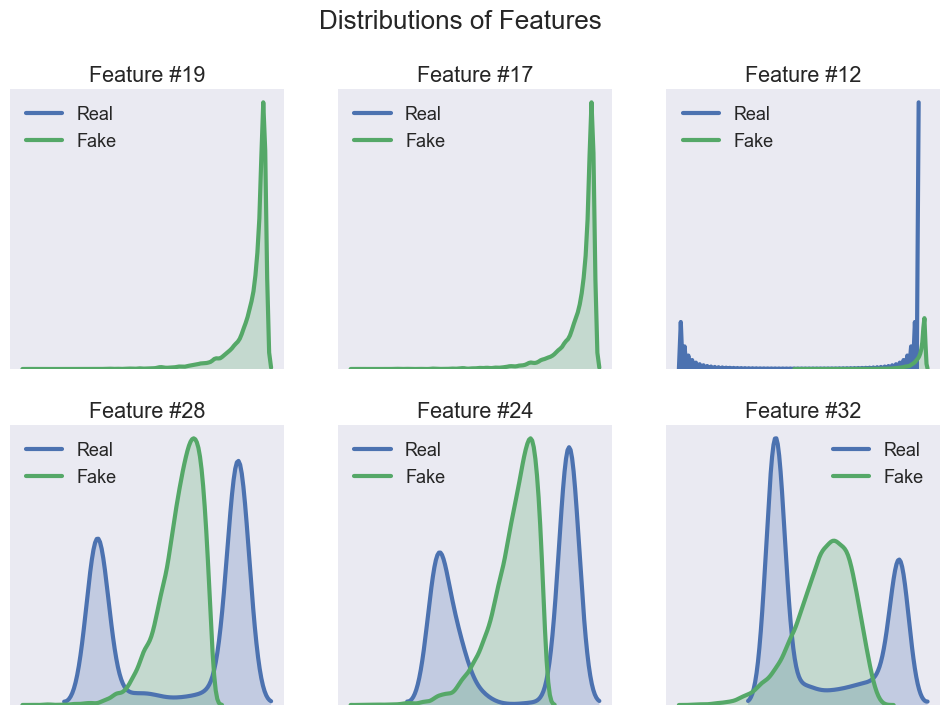

Epoch : 2611 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2621 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2631 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2641 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2651 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2661 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2671 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2681 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2691 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2701 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


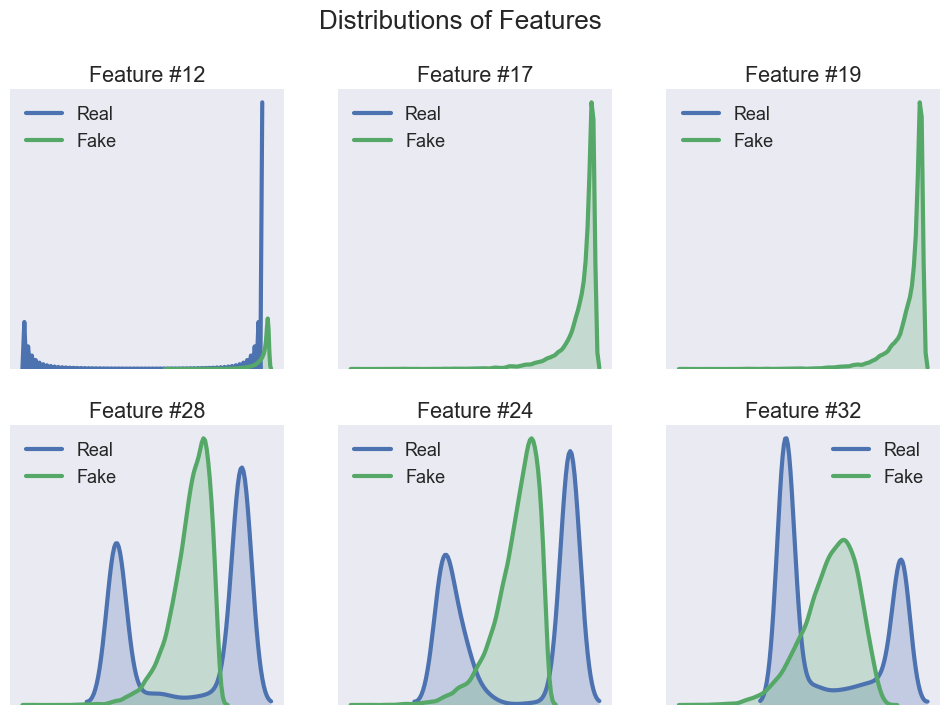

Epoch : 2711 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2721 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2731 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2741 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2751 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2761 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2771 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2781 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2791 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2801 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


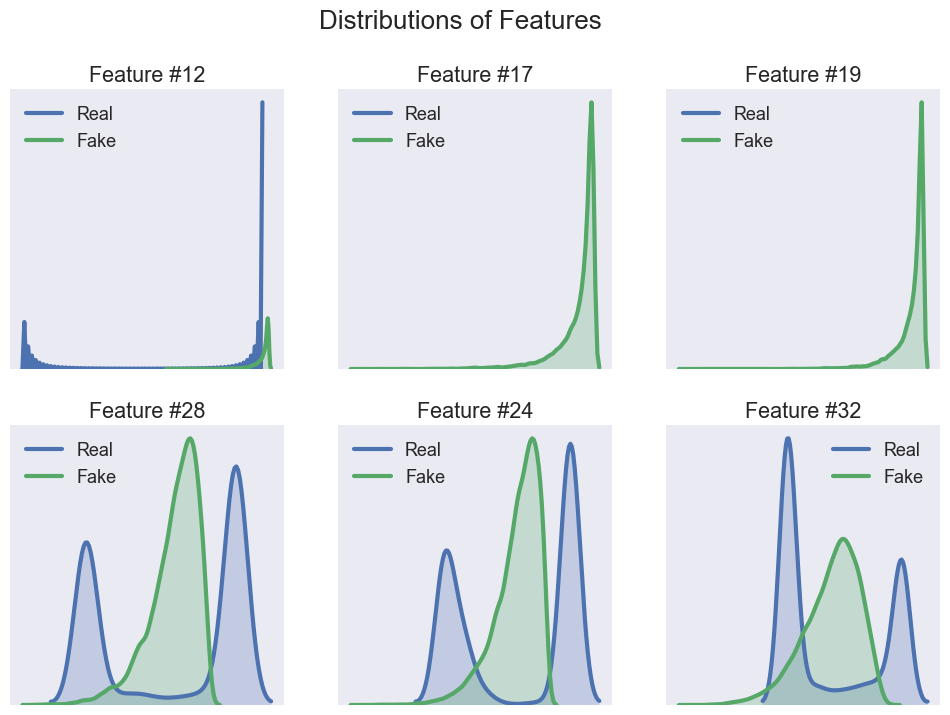

Epoch : 2811 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2821 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2831 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2841 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2851 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2861 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2871 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2881 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2891 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2901 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


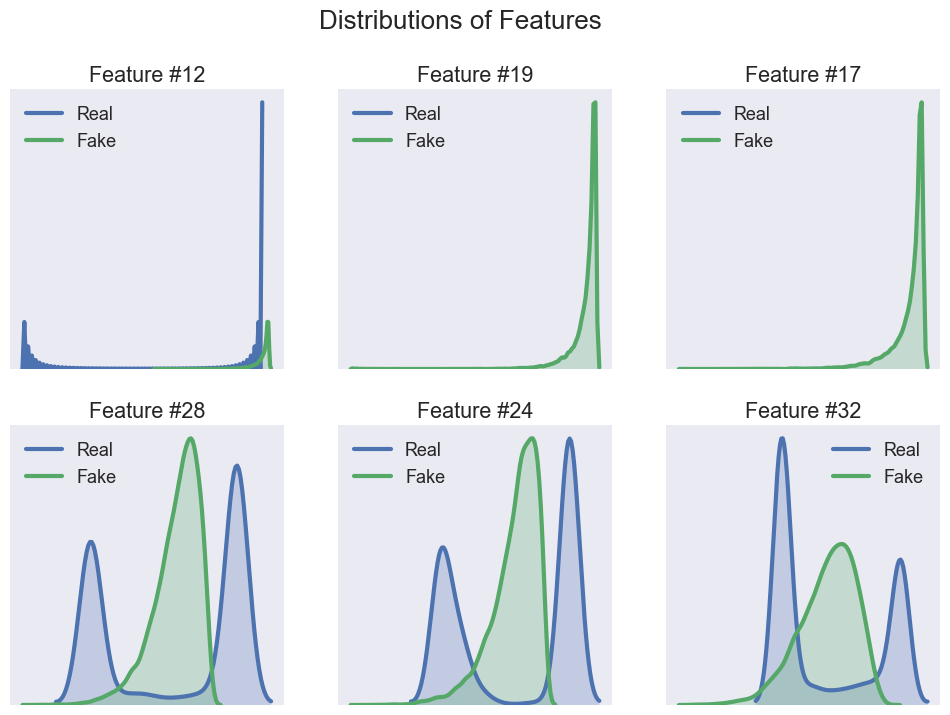

Epoch : 2911 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2921 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2931 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2941 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2951 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2961 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2971 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2981 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 2991 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3001 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


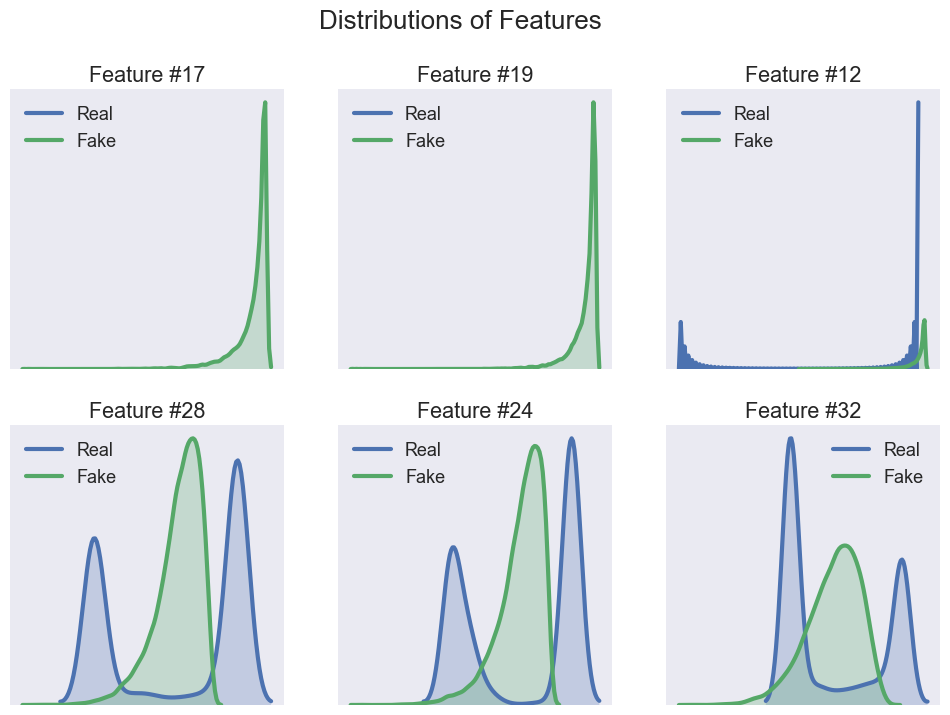

Epoch : 3011 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3021 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3031 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3041 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3051 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3061 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3071 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3081 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3091 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3101 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


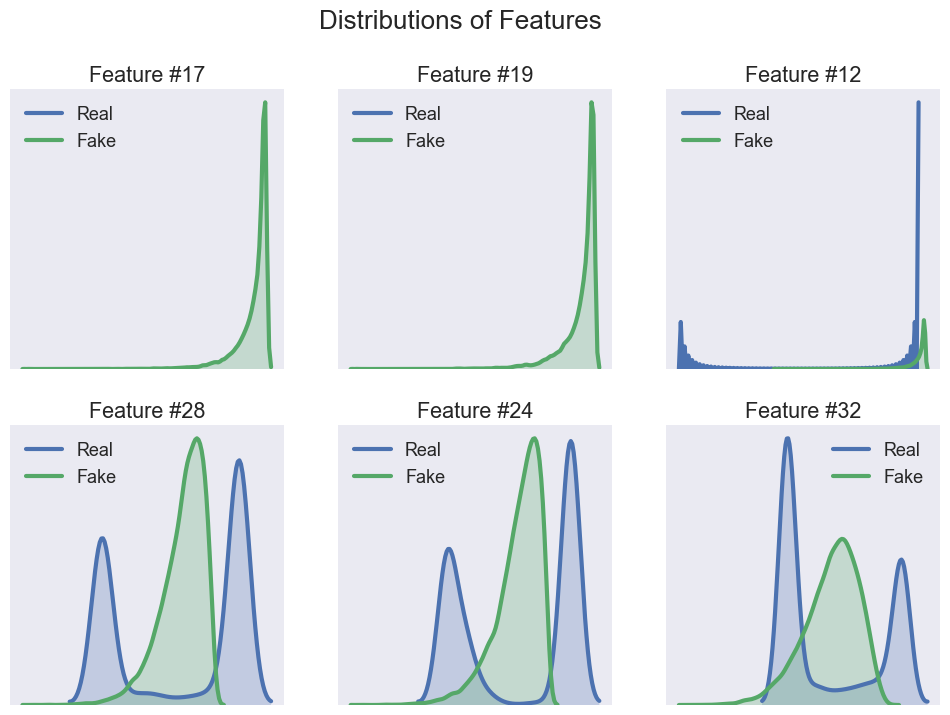

Epoch : 3111 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3121 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3131 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3141 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3151 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3161 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3171 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3181 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3191 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3201 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


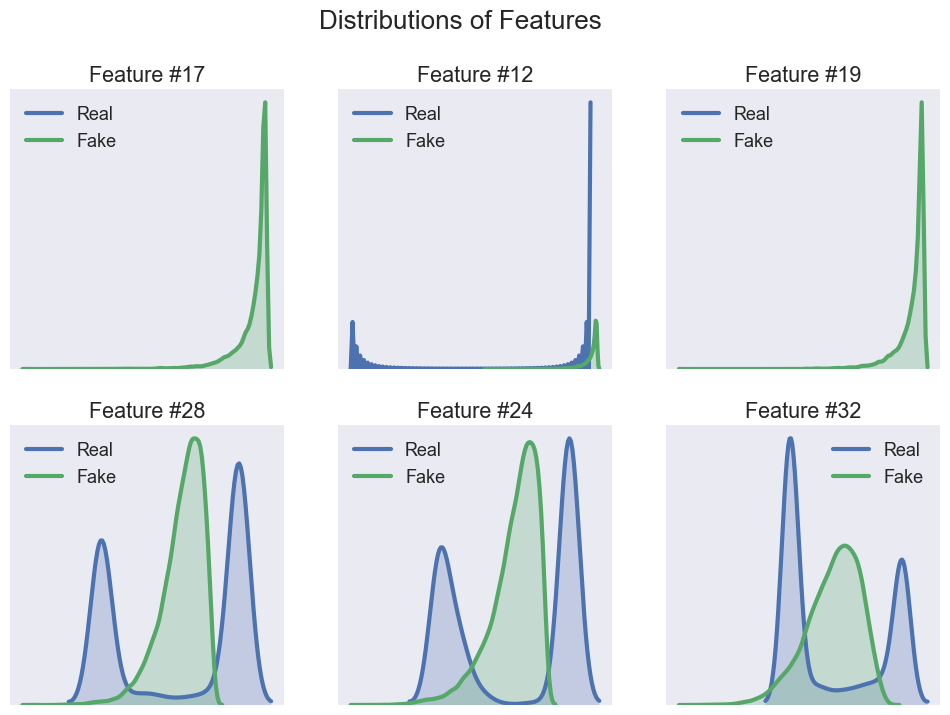

Epoch : 3211 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3221 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3231 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3241 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3251 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3261 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3271 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3281 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3291 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3301 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


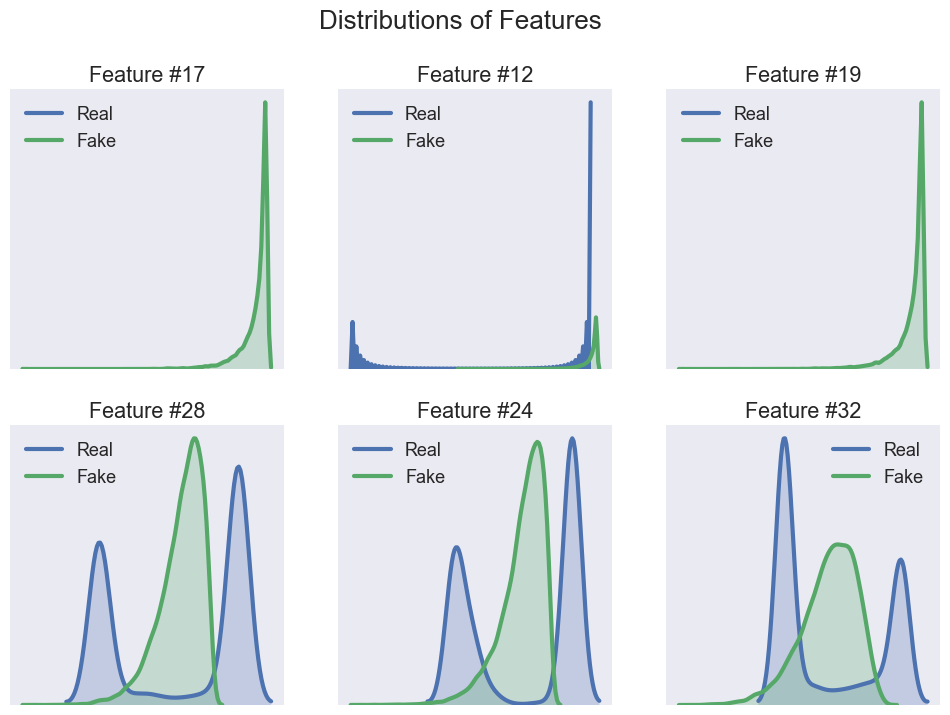

Epoch : 3311 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3321 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3331 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3341 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3351 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3361 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3371 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3381 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3391 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3401 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


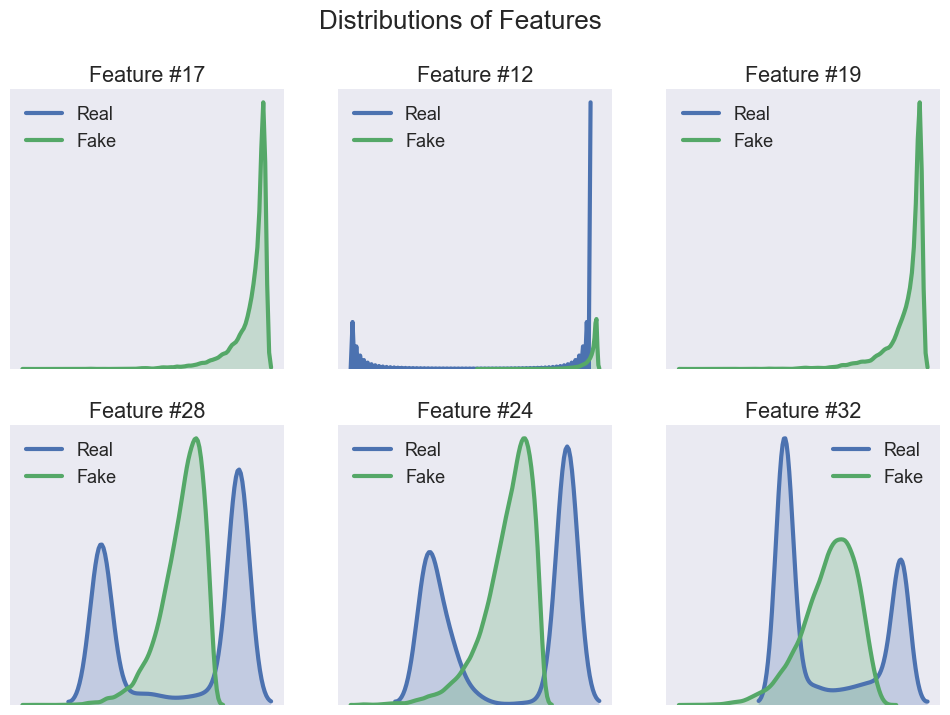

Epoch : 3411 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3421 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3431 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3441 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3451 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3461 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3471 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3481 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3491 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3501 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


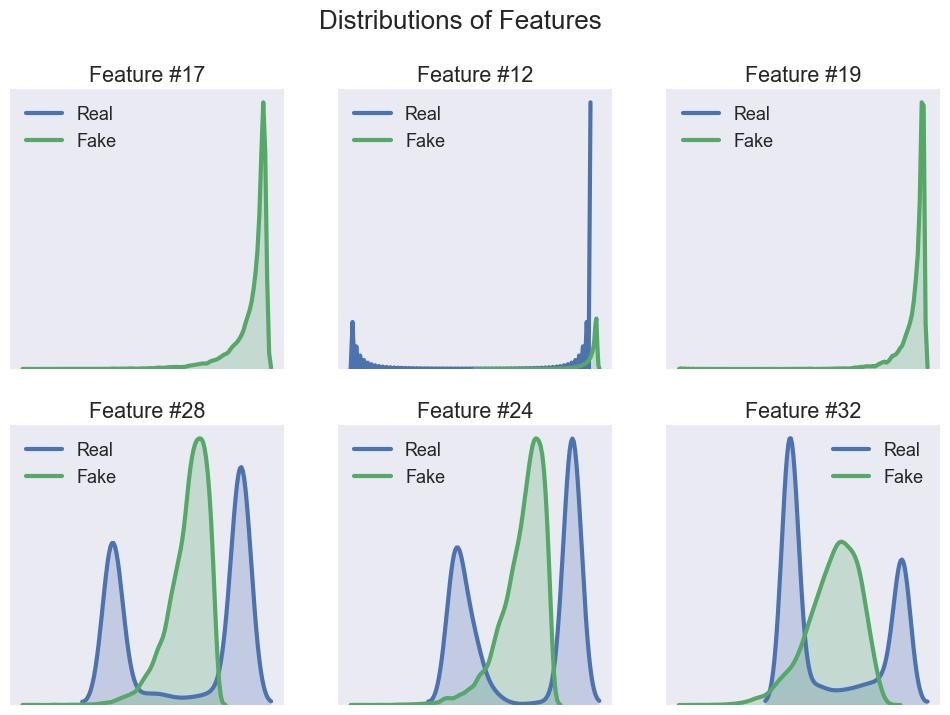

Epoch : 3511 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3521 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3531 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3541 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3551 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3561 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3571 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3581 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3591 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3601 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


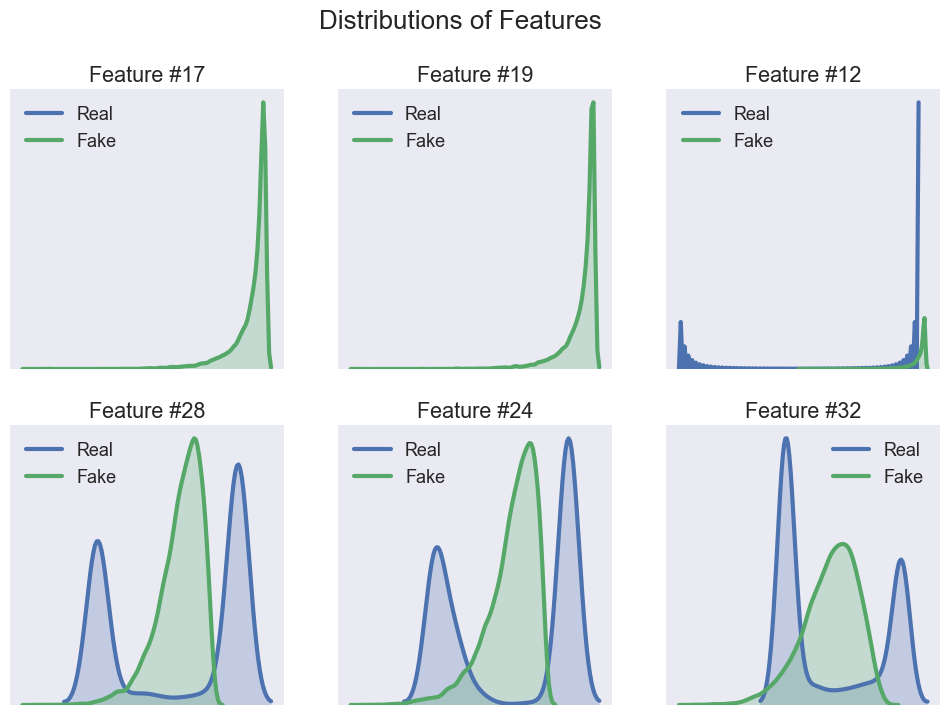

Epoch : 3611 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3621 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3631 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3641 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3651 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3661 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3671 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3681 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3691 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3701 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


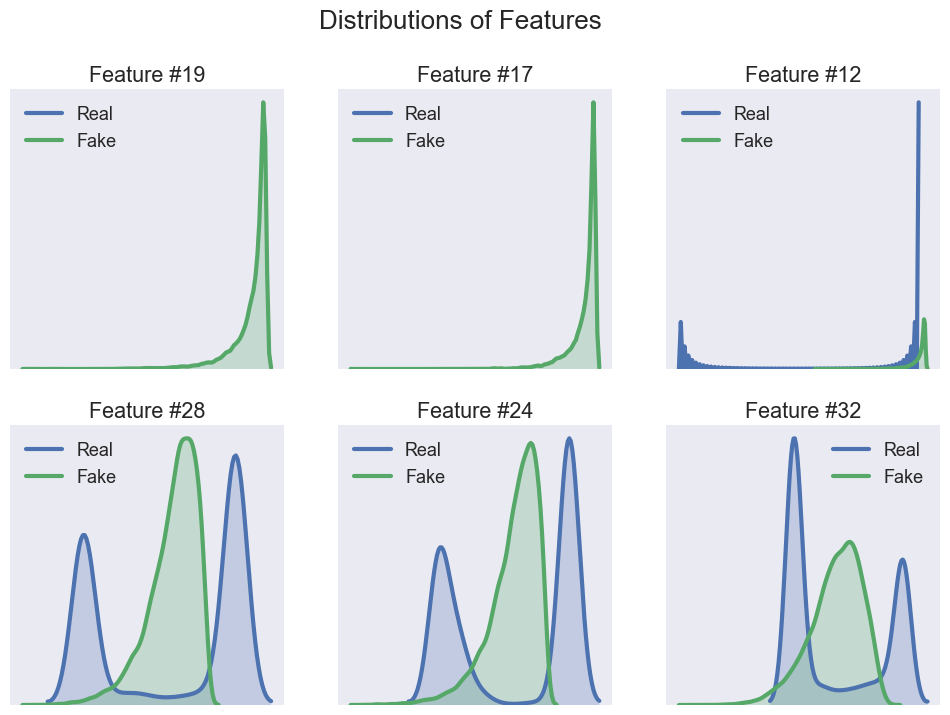

Epoch : 3711 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3721 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3731 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3741 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3751 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3761 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3771 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3781 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3791 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3801 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


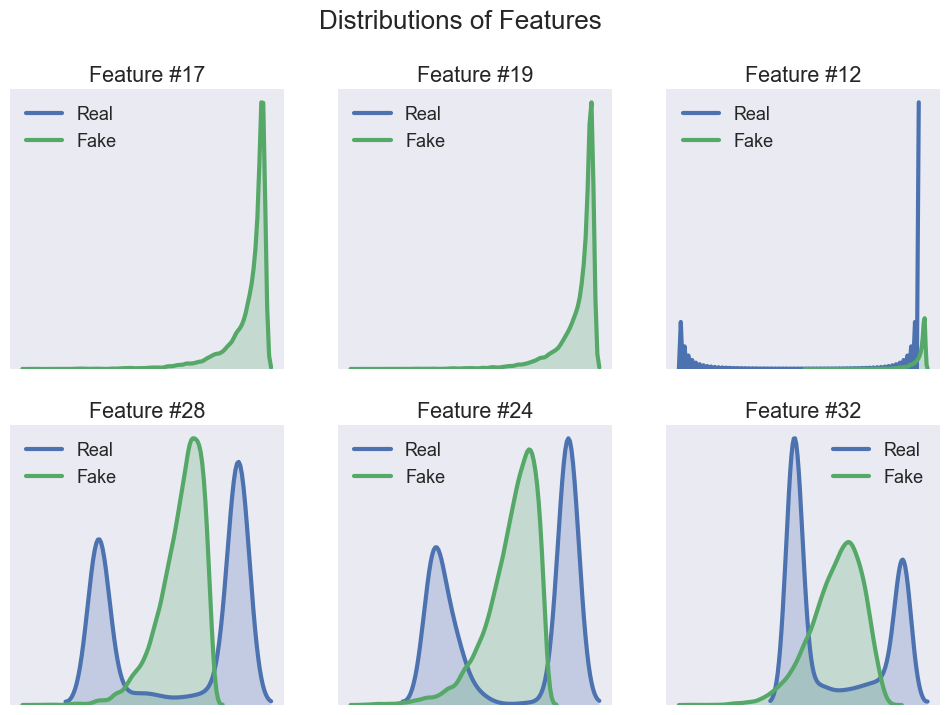

Epoch : 3811 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3821 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3831 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3841 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3851 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3861 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3871 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3881 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3891 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3901 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


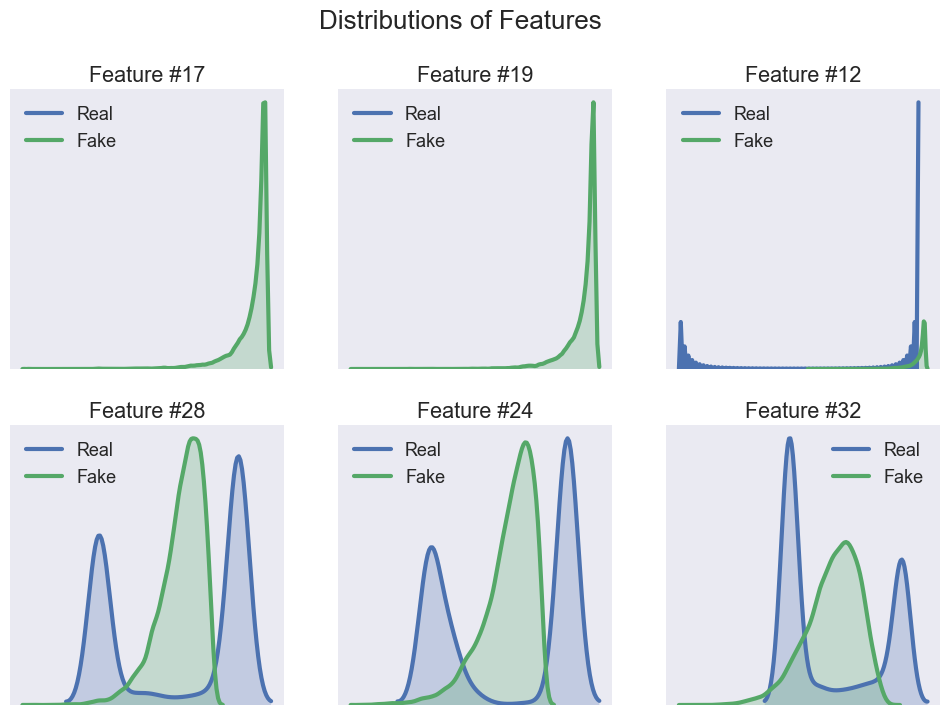

Epoch : 3911 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3921 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3931 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3941 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3951 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3961 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3971 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3981 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 3991 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4001 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


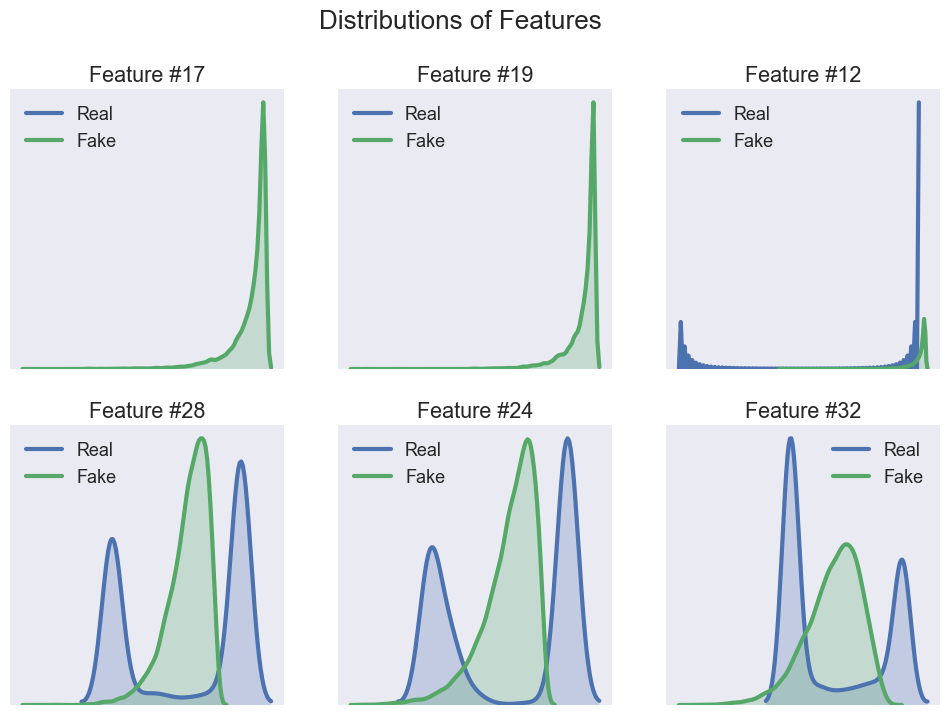

Epoch : 4011 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4021 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4031 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4041 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4051 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4061 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4071 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4081 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4091 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0
Epoch : 4101 , Generator loss -0.000070 
Critic accuracy on Real : 0.0 , Fake : 1.0


KeyboardInterrupt: 

In [18]:
results = training(dataset,base_n_neurones,rand_dim,n_epochs = epochs,n_critic=2)

## Plot loss

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0,len(results["generator_loss"])), results["generator_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
# results["disc_loss_generated"]

In [ ]:
z = np.random.normal(size=(10000, 32))
# results["combined_model"].predict(z)

In [ ]:
aa = results["generator_model"].predict(z)
r = results["critic_model"].predict(aa)
ww =[ -1.0 if i < 0.0 else 1.0 for i in r ]
accuracy_score(ww,-np.ones(len(aa)))

In [ ]:
X1 = np.random.normal(size = (100,10))
X2 = np.random.normal(size = (100,10))

p = norm.pdf(X1.T)
q = norm.pdf(X2.T)

norm_p = p/p.sum(axis=1,keepdims=1)
norm_q = q/q.sum(axis=1,keepdims=1)

In [ ]:
sns.set(rc={'figure.figsize':(16.7,12.27)},font_scale=1.3)
# sns.set_style("white")
# sns.set_context(font_scale=1.5)
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=0.2)
fig.suptitle('Distributions of Features')

for ax, feature, name in zip(axes.flatten(), [0,1,2,3,4,5], ["a","b","c","D","E","F"]):
    sns.distplot(norm_p[feature], hist = False, kde = True, ax = ax,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "Real")
    sns.distplot(norm_q[feature], hist = False, kde = True,ax = ax,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "Fake")
    #sns.distplot(feature, ax=ax, bins=len(np.unique(data.data.T[0]))//2)
    ax.set(title=name)
    
plt.show()